# Trabalho Computacional 3. Rede Convolucional e Transfer Learning

> **Nome**: *Gabriel Martins Silveira de Oliveira*.  
> **Matrícula**: 190042656.

# Verificação de Hardware

Antes de iniciarmos o trabalho, é fundamental definir alguns parâmetros para garantir a execução do notebook com o mínimo de interrupções. Inicialmente, considerou-se o uso da TPU (Tensor Processing Unit) do Google para otimizar os resultados. Contudo, essa opção não se mostrou prática devido à alta demanda e baixa disponibilidade desses recursos, dificultando o acesso.

Portanto, optaremos por utilizar apenas CUDA. Não é recomendado executar os experimentos utilizando somente a CPU. Caso esteja utilizando o Google Colab, recomenda-se fortemente o uso da GPU disponibilizada pela plataforma.

In [1]:
import os
import sys
import torch

IN_COLAB = "google.colab" in sys.modules
HAS_CUDA = torch.cuda.is_available()
NUM_CORES = os.cpu_count()
num_workers = NUM_CORES // 2 if NUM_CORES else 0
device_type = "gpu" if HAS_CUDA else "cpu"

colab_message = "Working in Google Colab\n" if IN_COLAB else ""
cuda_message = "Making use of CUDA\n" if HAS_CUDA else "No CUDA device found"
workers_message = f"With {num_workers} Workers"

print(colab_message + cuda_message + workers_message)

Making use of CUDA
With 4 Workers


# Importações Essenciais

Recomenda-se a execução deste código no Google Colab. No entanto, caso deseje executá-lo localmente, o arquivo `pyproject.toml` foi disponibilizado para a correta instalação das dependências.

In [2]:
# Google colab dependencies
if IN_COLAB:
    import subprocess
    try:
        subprocess.run(
                ["pip", "install", "pytorch-lightning", "torchmetrics"], check=True
            )
        print("Successfully installed packages.")
    except subprocess.CalledProcessError as e:
        print(f"Error installing packages: {e}")
        
# PyTorch
import torch
from torch import nn, optim, Generator
from torch.utils.data import random_split, Subset, DataLoader

# TorchVision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.models import (
    vgg16, 
    VGG16_Weights, 
    inception_v3, 
    Inception_V3_Weights,
)

# TorchMetrics
from torchmetrics.functional import accuracy

# TorchLightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

# Numpy
import numpy as np

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

# Utils
from pathlib import Path
from argparse import Namespace
from typing import List, Tuple, cast, Literal

# Dataset

Neste trabalho, utilizaremos a base de dados [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html).

Ela é composta por 60.000 imagens coloridas de 32x32 pixels (3 canais de cor).

Inicialmente, as imagens serão mantidas em suas dimensões originais. Esta abordagem permitirá avaliar diferentes configurações preliminares e identificar as mais promissoras no contexto do modelo mais simples. Posteriormente, ao explorar arquiteturas mais complexas, como o VGG16, será realizado o redimensionamento das imagens. Para essa etapa, será aplicado um dos métodos de pré-processamento que apresentou o melhor desempenho com o modelo base. Embora essa estratégia não garanta, necessariamente, um impacto positivo idêntico no novo modelo, espera-se que haja uma correlação positiva, influenciando o processo de ajuste dos pesos da rede.

In [3]:
class CIFAR10Dataset:
    """I did some chances to this class to make it easier to work with"""
    train: Subset[datasets.CIFAR10]
    val: Subset[datasets.CIFAR10]
    test: datasets.CIFAR10
    classes: List[str]
    resize: Tuple[int, int]

    def __init__(
        self,
        root: Path = Path("./.data/"),
        resize: Tuple[int, int] = (32, 32),
    ):
        trans = transforms.Compose(
            [
                transforms.Resize(resize),
                transforms.ToTensor(),
                transforms.Normalize(
                    (0.5, 0.5, 0.5),
                    (0.5, 0.5, 0.5),
                ),
            ]
        )

        self.full_train = datasets.CIFAR10(
            root=root, train=True, transform=trans, download=True
        )

        self.classes = self.full_train.classes

        train_set_size = int(len(self.full_train) * 0.8)
        valid_set_size = len(self.full_train) - train_set_size

        seed = Generator().manual_seed(42)
        self.train, self.val = random_split(
            self.full_train, [train_set_size, valid_set_size], generator=seed
        )

        self.test = datasets.CIFAR10(
            root=root, train=False, transform=trans, download=True
        )

    def get_dataloader(
        self,
        dataset_type: Literal["train", "test", "val"],
        batch_size: int = 64,
        num_workers: int = 2,
        shuffle: bool = False,
        persistent_workers: bool = True,
        pin_memory=True,
    ) -> DataLoader:
        
        dataset: Subset[datasets.CIFAR10] = getattr(self, dataset_type)
        if dataset_type == "train":
            shuffle = True
        return DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            persistent_workers=persistent_workers,
            pin_memory=pin_memory,
        )

In [4]:
root = Path("./.data/")
root.mkdir(parents=True, exist_ok=True)

In [5]:
dataset = CIFAR10Dataset(root=root)
train_dataloader = dataset.get_dataloader(dataset_type="train", num_workers=num_workers)
val_dataloader = dataset.get_dataloader(dataset_type="val", num_workers=num_workers)
test_dataloader = dataset.get_dataloader(dataset_type="val", num_workers=num_workers)

In [6]:
print(
    f"Number of training examples: {len(dataset.train):_}\n"
    f"Number of validation examples: {len(dataset.val):_}\n"
    f"Number of test examples: {len(dataset.test):_}\n\n"
    f"Number of Classes: {len(dataset.classes):_}\n"
    "Classes:",
    *dataset.classes,
    sep="\n  ",
)

Number of training examples: 40_000
Number of validation examples: 10_000
Number of test examples: 10_000

Number of Classes: 10
Classes:
  airplane
  automobile
  bird
  cat
  deer
  dog
  frog
  horse
  ship
  truck


Observa-se que o dataset é composto por 10 classes distintas. A divisão dos dados compreende 40.000 exemplos para treinamento, 10.000 para validação e 10.000 para teste. Abaixo, são apresentados alguns exemplos das imagens contidas neste conjunto.

In [7]:
def imshow_batch(
    images_batch: torch.Tensor,
    labels_batch: torch.Tensor,
    class_names: List[str],
    mean: float = 0.5,
    std: float = 0.5,
    num_images_to_show: int = 9,
):
    images_batch = images_batch.cpu()

    axes_grid_array: np.ndarray

    _, axes_grid_array = plt.subplots(
        3, 3, figsize=(10, 10)
    )

    axes_flat_array = axes_grid_array.flatten()

    for i in range(min(num_images_to_show, len(images_batch))):
        ax = axes_flat_array[i]
        assert isinstance(ax, Axes), "Each element should be an Axes object" # Pylance...

        # We need to unnormalize the image ):
        img = images_batch[i]
        img = img * std + mean
        img = img.permute(1, 2, 0)
        img = torch.clamp(img, 0, 1)
        
        ax.imshow(img.numpy())
        label_index: int = int(labels_batch[i].item())
        ax.set_title(f"Label: {class_names[label_index]}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

Displaying a batch of training images after transforms:


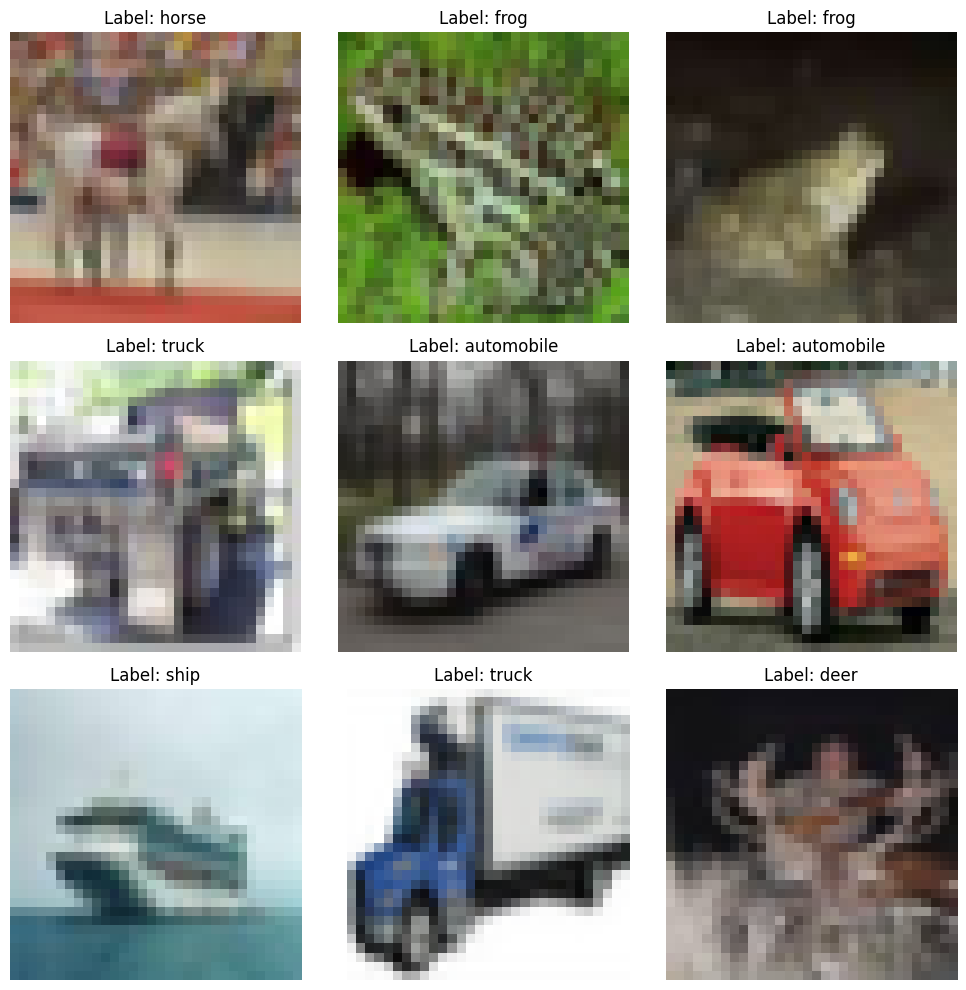

In [8]:
data_iter = iter(test_dataloader)
try:
    images, labels = next(data_iter)
    
    print("Displaying a batch of training images after transforms:")
    imshow_batch(images, labels, dataset.classes, num_images_to_show=9)

except StopIteration:
    print("DataLoader is empty or could not fetch a batch.")

# Treinamento de uma MLP Simples

Nesta etapa, será realizado o treinamento de uma Rede Perceptron Multicamadas (MLP) básica, composta por duas camadas ocultas. Para otimizar e gerenciar o processo de treinamento, será utilizada a biblioteca `PyTorch Lightning`.

Uma rotina de treinamento foi customizada para simplificar a aplicação de técnicas de regularização, como L2, L1 e dropout. Contudo, funcionalidades essenciais da biblioteca `PyTorch Lightning`, como o mecanismo de `EarlyStopping` (parada antecipada) e a classe `Trainer` para a orquestração do ciclo de treinamento, continuarão a ser empregadas.

In [9]:
class ModelHParams(Namespace):
    lr: float
    num_classes: int
    weight_decay: float  # L2 Regularization
    l1_strength: float  # L1 Regularization


class LightModel(pl.LightningModule):
    model: nn.Module
    hparams: ModelHParams

    def __init__(
        self,
        model: nn.Module,
        lr: float = 1e-3,
        num_classes: int = 10,
        weight_decay: float = 0.0,  # No L2 regularization
        l1_strength: float = 0.0,  # No L1 regularization
    ):
        super().__init__()
        self.save_hyperparameters(ignore=["model"])
        self.model = model

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        X, y = batch
        y_hat: torch.Tensor = self(X)
        cross_entropy_loss = nn.functional.cross_entropy(y_hat, y)
        total_loss = cross_entropy_loss

        if self.hparams.l1_strength > 0:
            total_loss = self._deal_with_l1(total_loss)
            
        self.log(
            "train_loss",
            total_loss,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
            sync_dist=True,
        )
        
        return total_loss

    def _deal_with_l1(self, total_loss: torch.Tensor) -> torch.Tensor:
        l1_penalty = 0.0
        for param in self.model.parameters():
            if param.requires_grad:
                l1_penalty += torch.norm(param, 1)  # L1 norm
        total_loss += self.hparams.l1_strength * l1_penalty
        return total_loss

    def validation_step(self, batch: Tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        X, y = batch
        y_hat: torch.Tensor = self(X)
        loss = nn.functional.cross_entropy(y_hat, y)
        self.log(
            "val_loss",
            loss,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
        )
        return loss

    def test_step(self, batch: Tuple[torch.Tensor, torch.Tensor]):
        X, y = batch
        y_hat: torch.Tensor = self(X)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy(
            preds,
            y,
            task="multiclass",
            num_classes=self.hparams.get("num_classes", 10),
        )
        self.log("test_acc", acc, on_epoch=True)
        loss = nn.functional.cross_entropy(y_hat, y)
        self.log("test_loss", loss, on_epoch=True)

    def configure_optimizers(self) -> optim.Optimizer:
        optimizer = optim.Adam(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay,
        )
        return optimizer

## Modelo Mais Simples

Este modelo inicial representa a configuração mais básica, sem a aplicação de técnicas de regularização L1 ou L2. Como função de ativação nas camadas ocultas, utiliza-se a ReLU. A arquitetura é detalhada no diagrama abaixo:

<center>

```mermaid
graph LR
    Input[Entrada<br/>Imagem 3x32x32<br/>Vetor de 3072 características] --> Hidden1(1ª Camada Oculta<br/>64 neurônios<br/>Ativação: ReLU);
    Hidden1 --> Hidden2(2ª Camada Oculta<br/>16 neurônios<br/>Ativação: ReLU);
    Hidden2 --> Output[Camada de Saída<br/>10 classes neurônios]
```
</center>


In [10]:
arch = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * 32 * 32, 64),
    nn.ReLU(),
    nn.Linear(64, 16),
    nn.ReLU(),
    nn.Linear(16, 10),
)
mlp = LightModel(arch)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5, 
    mode="min",
    min_delta=0.001,
)
trainer = Trainer(
    callbacks=[early_stopping], max_epochs=50, accelerator=device_type, devices=1
)
print("\n--- Training MLP classifier ---\n")
trainer.fit(
    model=mlp, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Dev\Coding\personal\Curso\ML\ENE0082\Trabalhos\Trabaho 3\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 197 


--- Training MLP classifier ---

Epoch 12: 100%|██████████| 625/625 [00:07<00:00, 80.22it/s, v_num=54, train_loss_step=1.420, val_loss=1.460, train_loss_epoch=1.130] 


In [11]:
print("\n--- Testing MPL classifier ---\n")
trainer.test(model=mlp, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Testing MPL classifier ---

Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 120.63it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5020999908447266
        test_loss           1.4607789516448975
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.5020999908447266, 'test_loss': 1.4607789516448975}]

**Conclusões sobre o Modelo Simples**

A acurácia obtida com o modelo simples situa-se em aproximadamente 50%. Embora este valor possa ser considerado modesto, tal desempenho era, em certa medida, esperado, dada a simplicidade da arquitetura empregada frente à tarefa de classificação.

Contudo, alcançar este patamar de acurácia, especialmente ao considerar a complexidade intrínseca das imagens do dataset (CIFAR-10) e sua baixa resolução (32x32 pixels), pode ser interpretado como um resultado inicial promissor. Este desempenho indica que o modelo conseguiu aprender algumas características relevantes dos dados, estabelecendo uma linha de base para futuras otimizações e a exploração de arquiteturas mais elaboradas.

## Modelo MLP com Regularização L1

Mantendo a mesma arquitetura e os mesmos hiperparâmetros do [modelo mais simples](#modelo-mais-simples), este modelo diferencia-se pela introdução da regularização L1.

In [12]:
arch = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * 32 * 32, 64),
    nn.ReLU(),
    nn.Linear(64, 16),
    nn.ReLU(),
    nn.Linear(16, 10),
)
mlp = LightModel(arch, l1_strength=1e-5)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5, 
    mode="min",
    min_delta=0.001,
)
trainer = Trainer(
    callbacks=[early_stopping], max_epochs=50, accelerator=device_type, devices=1
)
print("\n--- Training MLP classifier L1 ---\n")
trainer.fit(
    model=mlp, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 197 K  | train
---------------------------------------------
197 K     Trainable params
0         Non-trainable params
197 K     Total params
0.792     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode



--- Training MLP classifier L1 ---

Epoch 14: 100%|██████████| 625/625 [00:08<00:00, 73.09it/s, v_num=55, train_loss_step=1.380, val_loss=1.480, train_loss_epoch=1.240]


In [13]:
print("\n--- Testing MPL classifier L1---\n")
trainer.test(model=mlp, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Testing MPL classifier L1---

Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 132.00it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4975999891757965
        test_loss           1.4784318208694458
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.4975999891757965, 'test_loss': 1.4784318208694458}]

**Conclusões sobre o Modelo Simples com Regularização L1**

Os resultados de acurácia obtidos são praticamente idênticos aos do modelo sem regularização. Contudo, observou-se um período de treinamento mais longo.

## Modelo MLP com Regularização L2

Mantendo a mesma arquitetura e os mesmos hiperparâmetros do [modelo mais simples](#modelo-mais-simples), este modelo diferencia-se pela introdução da regularização L2.

In [14]:
arch = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * 32 * 32, 64),
    nn.ReLU(),
    nn.Linear(64, 16),
    nn.ReLU(),
    nn.Linear(16, 10),
)
mlp = LightModel(arch, weight_decay=1e-5)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5, 
    mode="min",
    min_delta=0.001,
)
trainer = Trainer(
    callbacks=[early_stopping], max_epochs=50, accelerator=device_type, devices=1
)
print("\n--- Training MLP classifier L2 ---\n")
trainer.fit(
    model=mlp, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 197 K  | train
---------------------------------------------
197 K     Trainable params
0         Non-trainable params
197 K     Total params
0.792     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode



--- Training MLP classifier L2 ---

Epoch 13: 100%|██████████| 625/625 [00:08<00:00, 77.24it/s, v_num=56, train_loss_step=1.140, val_loss=1.500, train_loss_epoch=1.120] 


In [15]:
print("\n--- Testing MPL classifier L2---\n")
trainer.test(model=mlp, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Testing MPL classifier L2---

Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 140.48it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4950000047683716
        test_loss           1.5034754276275635
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.4950000047683716, 'test_loss': 1.5034754276275635}]

**Conclusões sobre o Modelo Simples com Regularização L2**

Os resultados de acurácia obtidos foram, em geral, consistentes com os dos dois testes precedentes. Tempo de treinamento inalterado.

### Experimento com Leaky ReLU


<center>

```mermaid
graph LR
    Input[Entrada<br/>Imagem 3x32x32<br/>Vetor de 3072 características] --> Hidden1(1ª Camada Oculta<br/>64 neurônios<br/>Ativação: Leaky ReLU);
    Hidden1 --> Hidden2(2ª Camada Oculta<br/>16 neurônios<br/>Ativação: Leaky ReLU);
    Hidden2 --> Output[Camada de Saída<br/>10 classes neurônios]
```
</center>

In [16]:
arch_leaky = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * 32 * 32, 64),
    nn.LeakyReLU(),
    nn.Linear(64, 16),
    nn.LeakyReLU(),
    nn.Linear(16, 10),
)

mlp = LightModel(arch_leaky)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5, 
    mode="min",
    min_delta=0.001,
)
trainer = Trainer(
    callbacks=[early_stopping], max_epochs=50, accelerator=device_type, devices=1
)
print("\n--- Training MLP classifier Leaky ReLU---\n")
trainer.fit(
    model=mlp, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 197 K  | train
---------------------------------------------
197 K     Trainable params
0         Non-trainable params
197 K     Total params
0.792     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode



--- Training MLP classifier Leaky ReLU---

Epoch 10: 100%|██████████| 625/625 [00:07<00:00, 83.00it/s, v_num=57, train_loss_step=1.140, val_loss=1.430, train_loss_epoch=1.170] 


In [17]:
print("\n--- Testing MPL classifier Leaky ReLU---\n")
trainer.test(model=mlp, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Testing MPL classifier Leaky ReLU---

Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 137.43it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5091999769210815
        test_loss           1.4291560649871826
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.5091999769210815, 'test_loss': 1.4291560649871826}]

**Conclusões sobre o Experimento com Leaky ReLU**

Os resultados de desempenho foram similares aos obtidos em experimentos anteriores. Contudo, observou-se uma ligeira redução no tempo de treinamento.

## Modelo MLP com Dropout

Serão utilizados os mesmos parâmetros do [modelo simples](#modelo-mais-simples). Contudo, nesta iteração, será aplicada a técnica de Dropout com uma probabilidade de 50%, a fim de observar e analisar o impacto nos resultados.
<center>

```mermaid
graph LR
    Input[Entrada<br/>Imagem 3x32x32<br/>Vetor de 3072 características] --> Hidden1(1ª Camada Oculta<br/>64 neurônios<br/>Ativação: ReLU<br/>Dropout: 50%);
    Hidden1 --> Hidden2(2ª Camada Oculta<br/>16 neurônios<br/>Ativação: ReLU<br/>Dropout: 50%);
    Hidden2 --> Output[Camada de Saída<br/>10 classes neurônios]
```
</center>

In [18]:
dropout_p = 0.5
arch = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * 32 * 32, 64),
    nn.ReLU(),
    nn.Dropout(p=dropout_p),
    nn.Linear(64, 16),
    nn.ReLU(),
    nn.Dropout(p=dropout_p),
    nn.Linear(16, 10),
)

mlp = LightModel(arch)


early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5, 
    mode="min",
    min_delta=0.001,
)
trainer = Trainer(
    callbacks=[early_stopping], max_epochs=50, accelerator=device_type, devices=1
)
print("\n--- Training MLP classifier Dropout---\n")

trainer.fit(
    model=mlp, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 197 K  | train
---------------------------------------------
197 K     Trainable params
0         Non-trainable params
197 K     Total params
0.792     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode



--- Training MLP classifier Dropout---

Epoch 38: 100%|██████████| 625/625 [00:12<00:00, 49.66it/s, v_num=58, train_loss_step=1.810, val_loss=1.620, train_loss_epoch=1.760] 


In [19]:
print("\n--- Testing MPL classifier Dropout---\n")
trainer.test(model=mlp, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Testing MPL classifier Dropout---

Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 130.73it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4189999997615814
        test_loss           1.6188361644744873
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.4189999997615814, 'test_loss': 1.6188361644744873}]

**Conclusões sobre a MLP Simples com Dropout**

Observou-se um tempo de treinamento consideravelmente estendido, e a acurácia apresentou uma queda significativa. Esse resultado pode indicar que, para a arquitetura em questão, o Dropout não é a técnica de regularização mais adequada, visto que a simplicidade do modelo não demanda a aplicação dessa ferramenta.

## Variação do Número de Neurônios na MLP

Nesta etapa, será realizada a variação do número de neurônios nas camadas da MLP com o objetivo de identificar a configuração que otimize a acurácia do modelo.

In [20]:
arch = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * 32 * 32, 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
)

mlp = LightModel(arch)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5, 
    mode="min",
    min_delta=0.001,
)
trainer = Trainer(
    callbacks=[early_stopping], max_epochs=50, accelerator=device_type, devices=1
)
print("\n--- Training MLP classifier ---\n")
trainer.fit(
    model=mlp, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 803 K  | train
---------------------------------------------
803 K     Trainable params
0         Non-trainable params
803 K     Total params
3.215     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode



--- Training MLP classifier ---

Epoch 8: 100%|██████████| 625/625 [00:08<00:00, 74.68it/s, v_num=59, train_loss_step=1.070, val_loss=1.460, train_loss_epoch=0.965] 


In [21]:
print("\n--- Testing MPL classifier ---\n")
trainer.test(model=mlp, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Testing MPL classifier ---

Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 112.43it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5278000235557556
        test_loss           1.4579455852508545
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.5278000235557556, 'test_loss': 1.4579455852508545}]

**Conclusões sobre a Variação do Número de Neurônios**

Após uma série de experimentos, constatou-se que a configuração com 256 neurônios na primeira camada oculta e 64 neurônios na segunda resultou em um equilíbrio favorável entre acurácia e tempo de treinamento.

## Modelo MLP com Melhores Técnicas

Nesta etapa, serão aplicadas as melhores técnicas identificadas em experimentos anteriores, com o objetivo de otimizar o tempo de treinamento e maximizar a precisão. Isso inclui a utilização da função de ativação Leaky ReLU e a configuração do número ótimo de neurônios, conforme determinado previamente.

In [22]:
arch = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * 32 * 32, 256),
    nn.LeakyReLU(),
    nn.Linear(256, 64),
    nn.LeakyReLU(),
    nn.Linear(64, 10),
)

mlp = LightModel(arch)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5, 
    mode="min",
    min_delta=0.001,
)
trainer = Trainer(
    callbacks=[early_stopping], max_epochs=50, accelerator=device_type, devices=1
)
print("\n--- Training MLP classifier Best Techs ---\n")
trainer.fit(
    model=mlp, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 803 K  | train
---------------------------------------------
803 K     Trainable params
0         Non-trainable params
803 K     Total params
3.215     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode



--- Training MLP classifier Best Techs ---

Epoch 10: 100%|██████████| 625/625 [00:08<00:00, 73.06it/s, v_num=60, train_loss_step=0.645, val_loss=1.530, train_loss_epoch=0.855]


In [23]:
print("\n--- Testing MPL classifier Best Techs---\n")
trainer.test(model=mlp, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Testing MPL classifier Best Techs---

Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 118.93it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5249999761581421
        test_loss           1.5264487266540527
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.5249999761581421, 'test_loss': 1.5264487266540527}]

**Conclusões sobre a MLP com as Melhores Técnicas**

O tempo de treinamento transcorreu conforme o esperado, e a acurácia, por sua vez, mostrou-se bastante satisfatória.

## Uso da Rede VGG16 Pré-treinada

Nesta etapa, será empregada uma rede pré-treinada: a VGG16. A seguir, um diagrama ilustra sua arquitetura.

```mermaid
graph TD
    subgraph VGG_Model [VGG Model]
        direction LR

        Input([Input Image:<br/>3x224x224])

        subgraph Features_Block [Features]
            %%direction LR

            fb0["Layer: Conv2d<br/>In: 3, Out: 64, Kernel: 3x3, Stride: 1x1, Padding: 1x1<br/>Activator: ReLU"]
            fb1["Layer: Conv2d<br/>In: 64, Out: 64, Kernel: 3x3, Stride: 1x1, Padding: 1x1<br/>Activator: ReLU"]
            fb2["Layer: MaxPool2d<br/>Kernel: 2x2, Stride: 2x2"]

            fb3["Layer: Conv2d<br/>In: 64, Out: 128, Kernel: 3x3, Stride: 1x1, Padding: 1x1<br/>Activator: ReLU"]
            fb4["Layer: Conv2d<br/>In: 128, Out: 128, Kernel: 3x3, Stride: 1x1, Padding: 1x1<br/>Activator: ReLU"]
            fb5["Layer: MaxPool2d<br/>Kernel: 2x2, Stride: 2x2"]

            fb6["Layer: Conv2d<br/>In: 128, Out: 256, Kernel: 3x3, Stride: 1x1, Padding: 1x1<br/>Activator: ReLU"]
            fb7["Layer: Conv2d<br/>In: 256, Out: 256, Kernel: 3x3, Stride: 1x1, Padding: 1x1<br/>Activator: ReLU"]
            fb8["Layer: Conv2d<br/>In: 256, Out: 256, Kernel: 3x3, Stride: 1x1, Padding: 1x1<br/>Activator: ReLU"]
            fb9["Layer: MaxPool2d<br/>Kernel: 2x2, Stride: 2x2"]

            fb10["Layer: Conv2d<br/>In: 256, Out: 512, Kernel: 3x3, Stride: 1x1, Padding: 1x1<br/>Activator: ReLU"]
            fb11["Layer: Conv2d<br/>In: 512, Out: 512, Kernel: 3x3, Stride: 1x1, Padding: 1x1<br/>Activator: ReLU"]
            fb12["Layer: Conv2d<br/>In: 512, Out: 512, Kernel: 3x3, Stride: 1x1, Padding: 1x1<br/>Activator: ReLU"]
            fb13["Layer: MaxPool2d<br/>Kernel: 2x2, Stride: 2x2"]

            fb14["Layer: Conv2d<br/>In: 512, Out: 512, Kernel: 3x3, Stride: 1x1, Padding: 1x1<br/>Activator: ReLU"]
            fb15["Layer: Conv2d<br/>In: 512, Out: 512, Kernel: 3x3, Stride: 1x1, Padding: 1x1<br/>Activator: ReLU"]
            fb16["Layer: Conv2d<br/>In: 512, Out: 512, Kernel: 3x3, Stride: 1x1, Padding: 1x1<br/>Activator: ReLU"]
            fb17["Layer: MaxPool2d<br/>Kernel: 2x2, Stride: 2x2"]

            fb0 --> fb1 --> fb2 --> fb3 --> fb4 --> fb5 --> fb6 --> fb7 --> fb8 --> fb9 --> fb10
            fb10 --> fb11 --> fb12 --> fb13 --> fb14 --> fb15 --> fb16 --> fb17
        end

        AvgPool["(avgpool) Layer: AdaptiveAvgPool2d<br/>Output Size: 7x7"]

        subgraph Classifier_Block [Classifier]
            %%direction TD

            cb0["Layer: Linear<br/>In Feat: 25088, Out Feat: 4096<br/>Activator: ReLU"]
            cb1["Layer: Dropout<br/>p: 0.5"]
            cb2["Layer: Linear<br/>In Feat: 4096, Out Feat: 4096<br/>Activator: ReLU"]
            cb3["Layer: Dropout<br/>p: 0.5"]
            cb4["Layer: Linear<br/>In Feat: 4096, Out Feat: 1000"]

            cb0 --> cb1 --> cb2 --> cb3 --> cb4
        end

        Output([Output:<br/>1000 classes])

        Input --> Features_Block
        Features_Block --> AvgPool
        AvgPool --> Classifier_Block
        Classifier_Block --> Output
    end
```

Será realizada a modificação da camada classificadora da rede VGG16. A arquitetura VGG16 pré-treinada exige como entrada imagens com dimensões de 244x244 pixels e 3 canais de cor. Consequentemente, será necessário redimensionar o dataset para se adequar a este requisito.

Para otimizar o processo de treinamento, **será empregada a função de ativação Leaky ReLU**, uma vez que experimentos anteriores indicaram um aumento na velocidade de treinamento. Em contrapartida, **o Dropout não será aplicado**, pois testes prévios com modelos de menor complexidade demonstraram que essa técnica não resultou em benefícios significativos.

Abaixo, um diagrama ilustra a estrutura da nova camada classificadora que será definida. Além disso, as classes de saída também precisarão ser ajustadas para corresponder ao nosso problema de classificação.

```mermaid
graph LR   
    subgraph Classifier_Block [Classifier Block]
        direction LR
        cb0["Layer: Linear<br/>In Feat: 25088, Out Feat: 256<br/>Activator: Leaky ReLU"]
        cb2["Layer: Linear<br/>In Feat: 256, Out Feat: 64<br/>Activator: Leaky ReLU"]
        cb4["Layer: Linear<br/>In Feat: 64, Out Feat: 10"]

        cb0  --> cb2 --> cb4
    end
```

### Ajustar dataset Resize 244 x 244

In [24]:
dataset = CIFAR10Dataset(root=root, resize=(244, 244))
train_dataloader = dataset.get_dataloader(dataset_type="train", num_workers=num_workers)
val_dataloader = dataset.get_dataloader(dataset_type="val", num_workers=num_workers)
test_dataloader = dataset.get_dataloader(dataset_type="val", num_workers=num_workers)

### Requisição de Modelo

In [25]:
model_vgg = vgg16(weights=VGG16_Weights.DEFAULT, progress=True)

for param in model_vgg.parameters():
    param.requires_grad = False
    
in_features = cast(int, model_vgg.classifier[0].in_features) 

### Classifier Costumizado

In [26]:
custom_classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 64),
    nn.LeakyReLU(),
    nn.Linear(64, 10)
)
model_vgg.classifier = custom_classifier

light_vgg_model = LightModel(model=model_vgg)

In [27]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5, 
    mode="min",
    min_delta=0.001,
)
trainer = Trainer(
    callbacks=[early_stopping], max_epochs=50, accelerator=device_type, devices=1
)
print("\n--- Training VGG16 with custom classifier ---\n")
trainer.fit(
    model=light_vgg_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | VGG  | 17.9 M | train
---------------------------------------
3.2 M     Trainable params
14.7 M    Non-trainable params
17.9 M    Total params
71.740    Total estimated model params size (MB)
41        Modules in train mode
0         Modules in eval mode



--- Training VGG16 with custom classifier ---

Epoch 0:   0%|          | 2/625 [00:48<4:11:40,  0.04it/s, v_num=61, train_loss_step=2.260]

RuntimeError: Caught RuntimeError in pin memory thread for device 0.
Original Traceback (most recent call last):
  File "c:\Dev\Coding\personal\Curso\ML\ENE0082\Trabalhos\Trabaho 3\.venv\Lib\site-packages\torch\utils\data\_utils\pin_memory.py", line 43, in do_one_step
    data = pin_memory(data, device)
  File "c:\Dev\Coding\personal\Curso\ML\ENE0082\Trabalhos\Trabaho 3\.venv\Lib\site-packages\torch\utils\data\_utils\pin_memory.py", line 100, in pin_memory
    clone[i] = pin_memory(item, device)
               ~~~~~~~~~~^^^^^^^^^^^^^^
  File "c:\Dev\Coding\personal\Curso\ML\ENE0082\Trabalhos\Trabaho 3\.venv\Lib\site-packages\torch\utils\data\_utils\pin_memory.py", line 66, in pin_memory
    return data.pin_memory(device)
           ~~~~~~~~~~~~~~~^^^^^^^^
RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



In [ ]:
print("\n--- Testing VGG16 with custom classifier ---\n")
trainer.test(model=light_vgg_model, dataloaders=test_dataloader)

**Conclusões sobre o Modelo VGG16**

O tempo de treinamento para o modelo VGG16 foi consideravelmente extenso (95 Minutos). A acurácia alcançada foi de 81%, um resultado que pode ser considerado satisfatório.

Embora potenciais ajustes nos parâmetros das camadas de entrada e saída da camada classificadora pudessem, em tese, levar a uma acurácia ainda maior, a manutenção de um processo de treinamento tão prolongado é inviável.

Dessa forma, a acurácia de 81% é aceita como um resultado adequado para os propósitos deste estudo, considerando o *trade-off* entre desempenho e custo computacional.

## Modelo Inception V3 da Google

Nesta etapa, serão aplicadas as mesmas técnicas ao modelo Inception V3.

O modelo Inception V3 representa uma escolha adequada para esta aplicação, dada a sua natureza predominantemente convolucional e a simplicidade de sua camada de saída linear. Essas características sugerem uma boa capacidade de generalização para o dataset CIFAR-10, mesmo com uma entrada de complexidade relativamente menor em comparação aos dados de pré-treinamento.

```mermaid
graph TD
    subgraph Inception3_Model [InceptionV3 Model]
        %%direction TD

        Input([Input Image:<br/>3 channels])

        subgraph Stem_Block [Stem Layers]
            %%direction TD
            bc1a["Conv2d_1a_3x3:<br/>Conv(3, 32, k=3, s=2) + BN + ReLU"]
            bc2a["Conv2d_2a_3x3:<br/>Conv(32, 32, k=3, s=1) + BN + ReLU"]
            bc2b["Conv2d_2b_3x3:<br/>Conv(32, 64, k=3, s=1, p=1) + BN + ReLU"]
            mp1["maxpool1:<br/>MaxPool2d(k=3, s=2, p=0)"]
            bc3b["Conv2d_3b_1x1:<br/>Conv(64, 80, k=1, s=1) + BN + ReLU"]
            bc4a["Conv2d_4a_3x3:<br/>Conv(80, 192, k=3, s=1) + BN + ReLU"]
            mp2["maxpool2:<br/>MaxPool2d(k=3, s=2, p=0)"]

            bc1a --> bc2a --> bc2b --> mp1 --> bc3b --> bc4a --> mp2
        end

        subgraph Mixed_5b_Block ["Mixed_5b (InceptionA) Out: 256"]
            direction LR
            in_5b("Input(192)")

            subgraph Branch1x1_5b [Branch 1x1]
                bc1x1_5b["branch1x1:<br/>Conv(192, 64, k=1) + BN + ReLU"]
            end

            subgraph Branch5x5_5b [Branch 5x5]
                b5x5_1_5b["branch5x5_1:<br/>Conv(192, 48, k=1) + BN + ReLU"]
                b5x5_2_5b["branch5x5_2:<br/>Conv(48, 64, k=5, p=2) + BN + ReLU"]
                b5x5_1_5b --> b5x5_2_5b
            end

            subgraph Branch3x3dbl_5b [Branch 3x3 Dbl]
                b3x3dbl_1_5b["branch3x3dbl_1:<br/>Conv(192, 64, k=1) + BN + ReLU"]
                b3x3dbl_2_5b["branch3x3dbl_2:<br/>Conv(64, 96, k=3, p=1) + BN + ReLU"]
                b3x3dbl_3_5b["branch3x3dbl_3:<br/>Conv(96, 96, k=3, p=1) + BN + ReLU"]
                b3x3dbl_1_5b --> b3x3dbl_2_5b --> b3x3dbl_3_5b
            end

            subgraph BranchPool_5b [Branch Pool]
                mpool_5b("AvgPool2d(k=3, s=1, p=1)")
                bp_5b["branch_pool:<br/>Conv(192, 32, k=1) + BN + ReLU"]
                mpool_5b --> bp_5b
            end

            in_5b --"Input"--> Branch1x1_5b
            in_5b --"Input"--> Branch5x5_5b
            in_5b --"Input"--> Branch3x3dbl_5b
            in_5b --"Input"--> BranchPool_5b

            bc1x1_5b & b5x5_2_5b & b3x3dbl_3_5b & bp_5b --> Concat_5b((Concatenate:<br/>256 channels))
        end

        subgraph Mixed_5c_Block ["Mixed_5c (InceptionA) Out: 288"]
            direction LR
            in_5c("Input(256)")
            subgraph Branch1x1_5c
                bc1x1_5c["branch1x1:<br/>Conv(256, 64, k=1) + BN + ReLU"]
            end
            subgraph Branch5x5_5c
                b5x5_1_5c["branch5x5_1:<br/>Conv(256, 48, k=1) + BN + ReLU"]
                b5x5_2_5c["branch5x5_2:<br/>Conv(48, 64, k=5, p=2) + BN + ReLU"]
                b5x5_1_5c --> b5x5_2_5c
            end
            subgraph Branch3x3dbl_5c
                b3x3dbl_1_5c["branch3x3dbl_1:<br/>Conv(256, 64, k=1) + BN + ReLU"]
                b3x3dbl_2_5c["branch3x3dbl_2:<br/>Conv(64, 96, k=3, p=1) + BN + ReLU"]
                b3x3dbl_3_5c["branch3x3dbl_3:<br/>Conv(96, 96, k=3, p=1) + BN + ReLU"]
                b3x3dbl_1_5c --> b3x3dbl_2_5c --> b3x3dbl_3_5c
            end
            subgraph BranchPool_5c
                mpool_5c("AvgPool2d(k=3, s=1, p=1)")
                bp_5c["branch_pool:<br/>Conv(256, 64, k=1) + BN + ReLU"]
                mpool_5c --> bp_5c
            end
            in_5c --"Input"--> Branch1x1_5c
            in_5c --"Input"--> Branch5x5_5c
            in_5c --"Input"--> Branch3x3dbl_5c
            in_5c --"Input"--> BranchPool_5c
            bc1x1_5c & b5x5_2_5c & b3x3dbl_3_5c & bp_5c --> Concat_5c((Concatenate:<br/>288 channels))
        end

        subgraph Mixed_5d_Block ["Mixed_5d (InceptionA) Out: 288"]
            direction LR
            in_5d("Input(288)")
            subgraph Branch1x1_5d
                bc1x1_5d["branch1x1:<br/>Conv(288, 64, k=1) + BN + ReLU"]
            end
            subgraph Branch5x5_5d
                b5x5_1_5d["branch5x5_1:<br/>Conv(288, 48, k=1) + BN + ReLU"]
                b5x5_2_5d["branch5x5_2:<br/>Conv(48, 64, k=5, p=2) + BN + ReLU"]
                b5x5_1_5d --> b5x5_2_5d
            end
            subgraph Branch3x3dbl_5d
                b3x3dbl_1_5d["branch3x3dbl_1:<br/>Conv(288, 64, k=1) + BN + ReLU"]
                b3x3dbl_2_5d["branch3x3dbl_2:<br/>Conv(64, 96, k=3, p=1) + BN + ReLU"]
                b3x3dbl_3_5d["branch3x3dbl_3:<br/>Conv(96, 96, k=3, p=1) + BN + ReLU"]
                b3x3dbl_1_5d --> b3x3dbl_2_5d --> b3x3dbl_3_5d
            end
            subgraph BranchPool_5d
                mpool_5d("AvgPool2d(k=3, s=1, p=1)")
                bp_5d["branch_pool:<br/>Conv(288, 64, k=1) + BN + ReLU"]
                mpool_5d --> bp_5d
            end
            in_5d --"Input"--> Branch1x1_5d
            in_5d --"Input"--> Branch5x5_5d
            in_5d --"Input"--> Branch3x3dbl_5d
            in_5d --"Input"--> BranchPool_5d
            bc1x1_5d & b5x5_2_5d & b3x3dbl_3_5d & bp_5d --> Concat_5d((Concatenate:<br/>288 channels))
        end

        subgraph Mixed_6a_Block ["Mixed_6a (InceptionB) Out: 768"]
            direction LR
            in_6a("Input(288)")

            subgraph Branch3x3_6a [Branch 3x3]
                b3x3_6a["branch3x3:<br/>Conv(288, 384, k=3, s=2) + BN + ReLU"]
            end

            subgraph Branch3x3dbl_6a [Branch 3x3 Dbl]
                b3x3dbl_1_6a["branch3x3dbl_1:<br/>Conv(288, 64, k=1) + BN + ReLU"]
                b3x3dbl_2_6a["branch3x3dbl_2:<br/>Conv(64, 96, k=3, p=1) + BN + ReLU"]
                b3x3dbl_3_6a["branch3x3dbl_3:<br/>Conv(96, 96, k=3, s=2) + BN + ReLU"]
                b3x3dbl_1_6a --> b3x3dbl_2_6a --> b3x3dbl_3_6a
            end

            subgraph MaxPool_6a [Max Pool]
                mpool_6a("MaxPool2d(k=3, s=2, p=0)")
            end

            in_6a --"Input"--> Branch3x3_6a
            in_6a --"Input"--> Branch3x3dbl_6a
            in_6a --"Input"--> MaxPool_6a

            b3x3_6a & b3x3dbl_3_6a & mpool_6a --> Concat_6a((Concatenate:<br/>768 channels))
        end

        subgraph Mixed_6b_Block ["Mixed_6b (InceptionC) Out: 768"]
            direction LR
            in_6b("Input(768)")

            subgraph Branch1x1_6b [Branch 1x1]
                bc1x1_6b["branch1x1:<br/>Conv(768, 192, k=1) + BN + ReLU"]
            end

            subgraph Branch7x7_6b [Branch 7x7]
                b7x7_1_6b["branch7x7_1:<br/>Conv(768, 128, k=1) + BN + ReLU"]
                b7x7_2_6b["branch7x7_2:<br/>Conv(128, 128, k=1x7, p=0,3) + BN + ReLU"]
                b7x7_3_6b["branch7x7_3:<br/>Conv(128, 192, k=7x1, p=3,0) + BN + ReLU"]
                b7x7_1_6b --> b7x7_2_6b --> b7x7_3_6b
            end

            subgraph Branch7x7dbl_6b [Branch 7x7 Dbl]
                b7x7dbl_1_6b["branch7x7dbl_1:<br/>Conv(768, 128, k=1) + BN + ReLU"]
                b7x7dbl_2_6b["branch7x7dbl_2:<br/>Conv(128, 128, k=7x1, p=3,0) + BN + ReLU"]
                b7x7dbl_3_6b["branch7x7dbl_3:<br/>Conv(128, 128, k=1x7, p=0,3) + BN + ReLU"]
                b7x7dbl_4_6b["branch7x7dbl_4:<br/>Conv(128, 128, k=7x1, p=3,0) + BN + ReLU"]
                b7x7dbl_5_6b["branch7x7dbl_5:<br/>Conv(128, 192, k=1x7, p=0,3) + BN + ReLU"]
                b7x7dbl_1_6b --> b7x7dbl_2_6b --> b7x7dbl_3_6b --> b7x7dbl_4_6b --> b7x7dbl_5_6b
            end

            subgraph BranchPool_6b [Branch Pool]
                mpool_6b("AvgPool2d(k=3, s=1, p=1)")
                bp_6b["branch_pool:<br/>Conv(768, 192, k=1) + BN + ReLU"]
                mpool_6b --> bp_6b
            end

            in_6b --"Input"--> Branch1x1_6b
            in_6b --"Input"--> Branch7x7_6b
            in_6b --"Input"--> Branch7x7dbl_6b
            in_6b --"Input"--> BranchPool_6b

            bc1x1_6b & b7x7_3_6b & b7x7dbl_5_6b & bp_6b --> Concat_6b((Concatenate:<br/>768 channels))
        end

        subgraph Mixed_6c_Block ["Mixed_6c (InceptionC) Out: 768"]
            direction LR
            in_6c("Input(768)")
            subgraph Branch1x1_6c
                bc1x1_6c["branch1x1:<br/>Conv(768, 192, k=1) + BN + ReLU"]
            end
            subgraph Branch7x7_6c
                b7x7_1_6c["branch7x7_1:<br/>Conv(768, 160, k=1) + BN + ReLU"]
                b7x7_2_6c["branch7x7_2:<br/>Conv(160, 160, k=1x7, p=0,3) + BN + ReLU"]
                b7x7_3_6c["branch7x7_3:<br/>Conv(160, 192, k=7x1, p=3,0) + BN + ReLU"]
                b7x7_1_6c --> b7x7_2_6c --> b7x7_3_6c
            end
            subgraph Branch7x7dbl_6c
                b7x7dbl_1_6c["branch7x7dbl_1:<br/>Conv(768, 160, k=1) + BN + ReLU"]
                b7x7dbl_2_6c["branch7x7dbl_2:<br/>Conv(160, 160, k=7x1, p=3,0) + BN + ReLU"]
                b7x7dbl_3_6c["branch7x7dbl_3:<br/>Conv(160, 160, k=1x7, p=0,3) + BN + ReLU"]
                b7x7dbl_4_6c["branch7x7dbl_4:<br/>Conv(160, 160, k=7x1, p=3,0) + BN + ReLU"]
                b7x7dbl_5_6c["branch7x7dbl_5:<br/>Conv(160, 192, k=1x7, p=0,3) + BN + ReLU"]
                b7x7dbl_1_6c --> b7x7dbl_2_6c --> b7x7dbl_3_6c --> b7x7dbl_4_6c --> b7x7dbl_5_6c
            end
            subgraph BranchPool_6c
                mpool_6c("AvgPool2d(k=3, s=1, p=1)")
                bp_6c["branch_pool:<br/>Conv(768, 192, k=1) + BN + ReLU"]
                mpool_6c --> bp_6c
            end
            in_6c --"Input"--> Branch1x1_6c
            in_6c --"Input"--> Branch7x7_6c
            in_6c --"Input"--> Branch7x7dbl_6c
            in_6c --"Input"--> BranchPool_6c
            bc1x1_6c & b7x7_3_6c & b7x7dbl_5_6c & bp_6c --> Concat_6c((Concatenate:<br/>768 channels))
        end

        subgraph Mixed_6d_Block ["Mixed_6d (InceptionC) Out: 768"]
            direction LR
            in_6d("Input(768)")
            subgraph Branch1x1_6d
                bc1x1_6d["branch1x1:<br/>Conv(768, 192, k=1) + BN + ReLU"]
            end
            subgraph Branch7x7_6d
                b7x7_1_6d["branch7x7_1:<br/>Conv(768, 160, k=1) + BN + ReLU"]
                b7x7_2_6d["branch7x7_2:<br/>Conv(160, 160, k=1x7, p=0,3) + BN + ReLU"]
                b7x7_3_6d["branch7x7_3:<br/>Conv(160, 192, k=7x1, p=3,0) + BN + ReLU"]
                b7x7_1_6d --> b7x7_2_6d --> b7x7_3_6d
            end
            subgraph Branch7x7dbl_6d
                b7x7dbl_1_6d["branch7x7dbl_1:<br/>Conv(768, 160, k=1) + BN + ReLU"]
                b7x7dbl_2_6d["branch7x7dbl_2:<br/>Conv(160, 160, k=7x1, p=3,0) + BN + ReLU"]
                b7x7dbl_3_6d["branch7x7dbl_3:<br/>Conv(160, 160, k=1x7, p=0,3) + BN + ReLU"]
                b7x7dbl_4_6d["branch7x7dbl_4:<br/>Conv(160, 160, k=7x1, p=3,0) + BN + ReLU"]
                b7x7dbl_5_6d["branch7x7dbl_5:<br/>Conv(160, 192, k=1x7, p=0,3) + BN + ReLU"]
                b7x7dbl_1_6d --> b7x7dbl_2_6d --> b7x7dbl_3_6d --> b7x7dbl_4_6d --> b7x7dbl_5_6d
            end
            subgraph BranchPool_6d
                mpool_6d("AvgPool2d(k=3, s=1, p=1)")
                bp_6d["branch_pool:<br/>Conv(768, 192, k=1) + BN + ReLU"]
                mpool_6d --> bp_6d
            end
            in_6d --"Input"--> Branch1x1_6d
            in_6d --"Input"--> Branch7x7_6d
            in_6d --"Input"--> Branch7x7dbl_6d
            in_6d --"Input"--> BranchPool_6d
            bc1x1_6d & b7x7_3_6d & b7x7dbl_5_6d & bp_6d --> Concat_6d((Concatenate:<br/>768 channels))
        end

        subgraph Mixed_6e_Block ["Mixed_6e (InceptionC) Out: 768"]
            direction LR
            in_6e("Input(768)")
            subgraph Branch1x1_6e
                bc1x1_6e["branch1x1:<br/>Conv(768, 192, k=1) + BN + ReLU"]
            end
            subgraph Branch7x7_6e
                b7x7_1_6e["branch7x7_1:<br/>Conv(768, 192, k=1) + BN + ReLU"]
                b7x7_2_6e["branch7x7_2:<br/>Conv(192, 192, k=1x7, p=0,3) + BN + ReLU"]
                b7x7_3_6e["branch7x7_3:<br/>Conv(192, 192, k=7x1, p=3,0) + BN + ReLU"]
                b7x7_1_6e --> b7x7_2_6e --> b7x7_3_6e
            end
            subgraph Branch7x7dbl_6e
                b7x7dbl_1_6e["branch7x7dbl_1:<br/>Conv(768, 192, k=1) + BN + ReLU"]
                b7x7dbl_2_6e["branch7x7dbl_2:<br/>Conv(192, 192, k=7x1, p=3,0) + BN + ReLU"]
                b7x7dbl_3_6e["branch7x7dbl_3:<br/>Conv(192, 192, k=1x7, p=0,3) + BN + ReLU"]
                b7x7dbl_4_6e["branch7x7dbl_4:<br/>Conv(192, 192, k=7x1, p=3,0) + BN + ReLU"]
                b7x7dbl_5_6e["branch7x7dbl_5:<br/>Conv(192, 192, k=1x7, p=0,3) + BN + ReLU"]
                b7x7dbl_1_6e --> b7x7dbl_2_6e --> b7x7dbl_3_6e --> b7x7dbl_4_6e --> b7x7dbl_5_6e
            end
            subgraph BranchPool_6e
                mpool_6e("AvgPool2d(k=3, s=1, p=1)")
                bp_6e["branch_pool:<br/>Conv(768, 192, k=1) + BN + ReLU"]
                mpool_6e --> bp_6e
            end
            in_6e --"Input"--> Branch1x1_6e
            in_6e --"Input"--> Branch7x7_6e
            in_6e --"Input"--> Branch7x7dbl_6e
            in_6e --"Input"--> BranchPool_6e
            bc1x1_6e & b7x7_3_6e & b7x7dbl_5_6e & bp_6e --> Concat_6e((Concatenate:<br/>768 channels))
        end

        subgraph AuxLogits_Block [AuxLogits Classifier]
            %%direction TD
            in_aux("Input(768 from Mixed_6e)")
            aux_avgpool_5x5["Aux AvgPool:<br/>AdaptiveAvgPool2d(Out: (5,5))"]
            aux_conv0["conv0:<br/>Conv(768, 128, k=1) + BN + ReLU"]
            aux_conv1["conv1:<br/>Conv(128, 768, k=5) + BN + ReLU"]
            aux_avgpool_1x1["Aux AvgPool:<br/>AdaptiveAvgPool2d(Out: (1,1))"]
            aux_flatten["Flatten"]
            aux_fc["fc:<br/>Linear(768, 1000)"]
            in_aux --> aux_avgpool_5x5 --> aux_conv0 --> aux_conv1 --> aux_avgpool_1x1 --> aux_flatten --> aux_fc
        end

        subgraph Mixed_7a_Block ["Mixed_7a (InceptionD) Out: 1280"]
            direction LR
            in_7a("Input(768)")

            subgraph Branch3x3_7a [Branch 3x3]
                b3x3_1_7a["branch3x3_1:<br/>Conv(768, 192, k=1) + BN + ReLU"]
                b3x3_2_7a["branch3x3_2:<br/>Conv(192, 320, k=3, s=2) + BN + ReLU"]
                b3x3_1_7a --> b3x3_2_7a
            end

            subgraph Branch7x7x3_7a [Branch 7x7x3]
                b7x7x3_1_7a["branch7x7x3_1:<br/>Conv(768, 192, k=1) + BN + ReLU"]
                b7x7x3_2_7a["branch7x7x3_2:<br/>Conv(192, 192, k=1x7, p=0,3) + BN + ReLU"]
                b7x7x3_3_7a["branch7x7x3_3:<br/>Conv(192, 192, k=7x1, p=3,0) + BN + ReLU"]
                b7x7x3_4_7a["branch7x7x3_4:<br/>Conv(192, 192, k=3, s=2) + BN + ReLU"]
                b7x7x3_1_7a --> b7x7x3_2_7a --> b7x7x3_3_7a --> b7x7x3_4_7a
            end

            subgraph MaxPool_7a [Max Pool]
                mpool_7a("MaxPool2d(k=3, s=2, p=0)")
            end

            in_7a --"Input"--> Branch3x3_7a
            in_7a --"Input"--> Branch7x7x3_7a
            in_7a --"Input"--> MaxPool_7a

            b3x3_2_7a & b7x7x3_4_7a & mpool_7a --> Concat_7a((Concatenate:<br/>1280 channels))
        end

        subgraph Mixed_7b_Block ["Mixed_7b (InceptionE) Out: 2048"]
            direction LR
            in_7b("Input(1280)")

            subgraph Branch1x1_7b [Branch 1x1]
                bc1x1_7b["branch1x1:<br/>Conv(1280, 320, k=1) + BN + ReLU"]
            end

            subgraph Branch3x3_7b [Branch 3x3]
                b3x3_1_7b["branch3x3_1:<br/>Conv(1280, 384, k=1) + BN + ReLU"]
                split_3x3_7b{{"Split"}}
                b3x3_2a_7b["branch3x3_2a:<br/>Conv(384, 384, k=1x3, p=0,1) + BN + ReLU"]
                b3x3_2b_7b["branch3x3_2b:<br/>Conv(384, 384, k=3x1, p=1,0) + BN + ReLU"]
                b3x3_1_7b --> split_3x3_7b
                split_3x3_7b --"H-Split"--> b3x3_2a_7b
                split_3x3_7b --"V-Split"--> b3x3_2b_7b
                b3x3_2a_7b & b3x3_2b_7b --> Concat_3x3_7b((Concat: 768))
            end

            subgraph Branch3x3dbl_7b [Branch 3x3 Dbl]
                b3x3dbl_1_7b["branch3x3dbl_1:<br/>Conv(1280, 448, k=1) + BN + ReLU"]
                b3x3dbl_2_7b["branch3x3dbl_2:<br/>Conv(448, 384, k=3, p=1) + BN + ReLU"]
                split_3x3dbl_7b{{"Split"}}
                b3x3dbl_3a_7b["branch3x3dbl_3a:<br/>Conv(384, 384, k=1x3, p=0,1) + BN + ReLU"]
                b3x3dbl_3b_7b["branch3x3dbl_3b:<br/>Conv(384, 384, k=3x1, p=1,0) + BN + ReLU"]
                b3x3dbl_1_7b --> b3x3dbl_2_7b --> split_3x3dbl_7b
                split_3x3dbl_7b --"H-Split"--> b3x3dbl_3a_7b
                split_3x3dbl_7b --"V-Split"--> b3x3dbl_3b_7b
                b3x3dbl_3a_7b & b3x3dbl_3b_7b --> Concat_3x3dbl_7b((Concat: 768))
            end

            subgraph BranchPool_7b [Branch Pool]
                mpool_7b("AvgPool2d(k=3, s=1, p=1)")
                bp_7b["branch_pool:<br/>Conv(1280, 192, k=1) + BN + ReLU"]
                mpool_7b --> bp_7b
            end

            in_7b --"Input"--> Branch1x1_7b
            in_7b --"Input"--> Branch3x3_7b
            in_7b --"Input"--> Branch3x3dbl_7b
            in_7b --"Input"--> BranchPool_7b

            bc1x1_7b & Concat_3x3_7b & Concat_3x3dbl_7b & bp_7b --> Concat_7b((Concatenate:<br/>2048 channels))
        end

        subgraph Mixed_7c_Block ["Mixed_7c (InceptionE) Out: 2048"]
            direction LR
            in_7c("Input(2048)")
            subgraph Branch1x1_7c
                bc1x1_7c["branch1x1:<br/>Conv(2048, 320, k=1) + BN + ReLU"]
            end
            subgraph Branch3x3_7c
                b3x3_1_7c["branch3x3_1:<br/>Conv(2048, 384, k=1) + BN + ReLU"]
                split_3x3_7c{{"Split"}}
                b3x3_2a_7c["branch3x3_2a:<br/>Conv(384, 384, k=1x3, p=0,1) + BN + ReLU"]
                b3x3_2b_7c["branch3x3_2b:<br/>Conv(384, 384, k=3x1, p=1,0) + BN + ReLU"]
                b3x3_1_7c --> split_3x3_7c
                split_3x3_7c --"H-Split"--> b3x3_2a_7c
                split_3x3_7c --"V-Split"--> b3x3_2b_7c
                b3x3_2a_7c & b3x3_2b_7c --> Concat_3x3_7c((Concat: 768))
            end
            subgraph Branch3x3dbl_7c
                b3x3dbl_1_7c["branch3x3dbl_1:<br/>Conv(2048, 448, k=1) + BN + ReLU"]
                b3x3dbl_2_7c["branch3x3dbl_2:<br/>Conv(448, 384, k=3, p=1) + BN + ReLU"]
                split_3x3dbl_7c{{"Split"}}
                b3x3dbl_3a_7c["branch3x3dbl_3a:<br/>Conv(384, 384, k=1x3, p=0,1) + BN + ReLU"]
                b3x3dbl_3b_7c["branch3x3dbl_3b:<br/>Conv(384, 384, k=3x1, p=1,0) + BN + ReLU"]
                b3x3dbl_1_7c --> b3x3dbl_2_7c --> split_3x3dbl_7c
                split_3x3dbl_7c --"H-Split"--> b3x3dbl_3a_7c
                split_3x3dbl_7c --"V-Split"--> b3x3dbl_3b_7c
                b3x3dbl_3a_7c & b3x3dbl_3b_7c --> Concat_3x3dbl_7c((Concat: 768))
            end
            subgraph BranchPool_7c
                mpool_7c("AvgPool2d(k=3, s=1, p=1)")
                bp_7c["branch_pool:<br/>Conv(2048, 192, k=1) + BN + ReLU"]
                mpool_7c --> bp_7c
            end
            in_7c --"Input"--> Branch1x1_7c
            in_7c --"Input"--> Branch3x3_7c
            in_7c --"Input"--> Branch3x3dbl_7c
            in_7c --"Input"--> BranchPool_7c
            bc1x1_7c & Concat_3x3_7c & Concat_3x3dbl_7c & bp_7c --> Concat_7c((Concatenate:<br/>2048 channels))
        end

        subgraph Final_Layers [Classifier Head]
            avgpool["avgpool:<br/>AdaptiveAvgPool2d(Out: (1,1))"]
            dropout["dropout:<br/>Dropout(p=0.5)"]
            fc["fc:<br/>Linear(2048, 1000)"]
            avgpool --> dropout --> fc
        end

        Input --> Stem_Block
        Stem_Block --> Mixed_5b_Block
        Mixed_5b_Block --> Mixed_5c_Block
        Mixed_5c_Block --> Mixed_5d_Block
        Mixed_5d_Block --> Mixed_6a_Block
        Mixed_6a_Block --> Mixed_6b_Block
        Mixed_6b_Block --> Mixed_6c_Block
        Mixed_6c_Block --> Mixed_6d_Block
        Mixed_6d_Block --> Mixed_6e_Block

        Mixed_6e_Block --"Main path"--> Mixed_7a_Block
        Mixed_6e_Block --"Auxiliary path"--> AuxLogits_Block

        Mixed_7a_Block --> Mixed_7b_Block
        Mixed_7b_Block --> Mixed_7c_Block
        Mixed_7c_Block --> Final_Layers
        Final_Layers --> Output
    end
```

## Redimensionamento do Dataset para 299x299 Pixels

Nesta etapa, o dataset será redimensionado para que as imagens possuam as dimensões de 299x299 pixels, tornando-as compatíveis com a entrada esperada pelo modelo Inception V3.

Dada a alta demanda computacional deste modelo e a limitação de 4 GB de VRAM do sistema, será necessário reduzir o tamanho do *batch*.

In [ ]:
dataset = CIFAR10Dataset(root=root, resize=(299, 299))
train_dataloader = dataset.get_dataloader(dataset_type="train", num_workers=num_workers, batch_size=50)
val_dataloader = dataset.get_dataloader(dataset_type="val", num_workers=num_workers, batch_size=50)
test_dataloader = dataset.get_dataloader(dataset_type="val", num_workers=num_workers, batch_size=50)

In [ ]:
model_inception = inception_v3(weights=Inception_V3_Weights.DEFAULT, progress=True)
model_inception.aux_logits = False

for param in model_inception.parameters():
    param.requires_grad = False
    
in_features_inception = model_inception.fc.in_features

custom_classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features_inception, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 64),
    nn.LeakyReLU(),
    nn.Linear(64, 10)
)

# Pylance will complain about the data type, fc is Linear
model_inception.fc = custom_classifier  # type: ignore

light_inception_model = LightModel(model_inception)

In [ ]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="min",
    min_delta=0.001,
)
trainer = Trainer(
    callbacks=[early_stopping],
    max_epochs=50,
    accelerator=device_type,
    devices=1,
    # accumulate_grad_batches=2, # If were to reduce more batch size
)
print("\n--- Training Inception with custom classifier ---\n")
trainer.fit(
    model=light_inception_model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

In [ ]:
print("\n--- Testing Inception with custom classifier ---\n")
trainer.test(model=light_inception_model, dataloaders=test_dataloader)